In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib

In [2]:
data_dir = './dataset/2_class'

In [3]:
# pathlib is better than os.path
data_root = pathlib.Path(data_dir)

In [4]:
# have a look at the path
for file in data_root.iterdir():
    print(file)

dataset\2_class\airplane
dataset\2_class\lake


In [5]:
# get all the images(their path)
all_image = list(data_root.glob('*/*'))

In [6]:
all_image[-3:]

[WindowsPath('dataset/2_class/lake/lake_698.jpg'),
 WindowsPath('dataset/2_class/lake/lake_699.jpg'),
 WindowsPath('dataset/2_class/lake/lake_700.jpg')]

In [7]:
# convert WindowsPath format to string format
all_img_paths = [str(path) for path in all_image]

In [8]:
all_img_paths[-3:]

['dataset\\2_class\\lake\\lake_698.jpg',
 'dataset\\2_class\\lake\\lake_699.jpg',
 'dataset\\2_class\\lake\\lake_700.jpg']

In [9]:
import random

In [10]:
random.shuffle(all_img_paths)

In [11]:
all_img_paths[-3:]

['dataset\\2_class\\airplane\\airplane_381.jpg',
 'dataset\\2_class\\airplane\\airplane_024.jpg',
 'dataset\\2_class\\lake\\lake_427.jpg']

In [12]:
num_of_images = len(all_img_paths)

In [13]:
label_names = sorted(item.name for item in data_root.glob('*/'))

In [14]:
label_names

['airplane', 'lake']

In [15]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))

In [16]:
label_to_index

{'airplane': 0, 'lake': 1}

In [17]:
# label the images

In [18]:
pathlib.Path('dataset\\2_class\\lake\\lake_700.jpg').parent.name

'lake'

In [19]:
all_img_labels = [label_to_index[pathlib.Path(p).parent.name] for p in all_img_paths]

In [20]:
all_img_labels[: 5]

[0, 1, 1, 1, 0]

In [21]:
import IPython.display as display

In [22]:
index_to_label = dict((value, key) for key, value in label_to_index.items())

In [23]:
index_to_label

{0: 'airplane', 1: 'lake'}

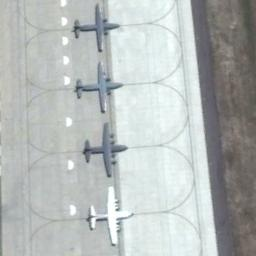

airplane



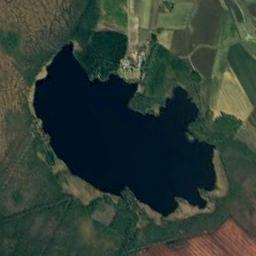

lake



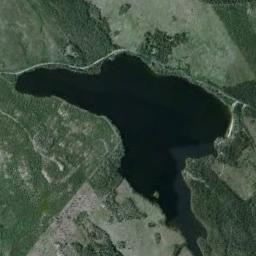

lake



In [24]:
# randomly pick 3 images to show
for _ in range(3):
    img_index = random.choice(range(len(all_img_paths)))
    display.display(display.Image(all_img_paths[img_index]))
    print(index_to_label[all_img_labels[img_index]])
    print()

In [25]:
# read the picture to tf.dataset format(as training input matrix)

In [26]:
img_path = all_img_paths[0]

In [27]:
img_path

'dataset\\2_class\\airplane\\airplane_016.jpg'

In [28]:
# read the picture to a binary format
img_raw = tf.io.read_file(img_path)

In [29]:
img_tensor = tf.image.decode_image(img_raw)

In [30]:
img_tensor.shape

TensorShape([256, 256, 3])

In [31]:
img_tensor.dtype

tf.uint8

In [32]:
img_tensor = tf.cast(img_tensor, tf.float32)

In [33]:
img_tensor = img_tensor / 255

In [34]:
def load_preprocessed_img(img_path):
    img_raw = tf.io.read_file(img_path)
    img_tensor = tf.image.decode_jpeg(img_raw, channels=3)
    img_tensor = tf.image.resize(img_tensor, [256, 256])
    img_tensor = tf.cast(img_tensor, tf.float32)
    img = img_tensor / 255
    return img

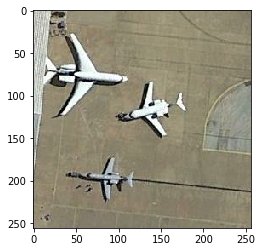

In [35]:
plt.imshow(load_preprocessed_img(all_img_paths[100]))

In [36]:
path_ds = tf.data.Dataset.from_tensor_slices(all_img_paths)
img_dataset = path_ds.map(load_preprocessed_img)

label_dataset = tf.data.Dataset.from_tensor_slices(all_img_labels)


In [37]:
img_dataset

<MapDataset shapes: (256, 256, 3), types: tf.float32>

In [38]:
dataset = tf.data.Dataset.zip((img_dataset, label_dataset))

In [39]:
dataset

<ZipDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>

In [40]:
# divide the whole dataset to train, validation set
num_test = int(num_of_images * 0.2)
num_train = num_of_images - num_test

In [41]:
num_test, num_train

(280, 1120)

In [42]:
# divide
training_set = dataset.take(num_train)
test_set = dataset.skip(num_train)

BATCH_SIZE = 32
training_set = training_set.shuffle(num_train).repeat().batch(BATCH_SIZE)
test_set = test_set.batch(BATCH_SIZE)

In [43]:
training_set

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [44]:
# the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [45]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [46]:
steps_per_epoch = num_train // BATCH_SIZE
validation_steps = num_test // BATCH_SIZE

In [47]:
history = model.fit(training_set, epochs=30, steps_per_epoch=steps_per_epoch, validation_data=test_set)

Epoch 1/30


W0802 01:43:00.600825 18132 deprecation.py:323] From D:\work\Python\Python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


35/35 [==============================] - 29s 834ms/step - loss: 0.6956 - acc: 0.5482 - val_loss: 0.6938 - val_acc: 0.4964
Epoch 2/30
35/35 [==============================] - 17s 487ms/step - loss: 0.6800 - acc: 0.5777 - val_loss: 0.6349 - val_acc: 0.8607
Epoch 3/30
35/35 [==============================] - 17s 485ms/step - loss: 0.5560 - acc: 0.8152 - val_loss: 0.1161 - val_acc: 0.9536
Epoch 4/30
35/35 [==============================] - 17s 491ms/step - loss: 0.1715 - acc: 0.9393 - val_loss: 0.2189 - val_acc: 0.9821
Epoch 5/30
35/35 [==============================] - 17s 486ms/step - loss: 0.3058 - acc: 0.9071 - val_loss: 0.3118 - val_acc: 0.9750
Epoch 6/30
35/35 [==============================] - 18s 513ms/step - loss: 0.2412 - acc: 0.9455 - val_loss: 0.0973 - val_acc: 0.9643
Epoch 7/30
35/35 [==============================] - 17s 490ms/step - loss: 0.1535 - acc: 0.9571 - val_loss: 0.1472 - val_acc: 0.9714
Epoch 8/30
35/35 [==============================] - 18s 503ms/step - loss: 0.136

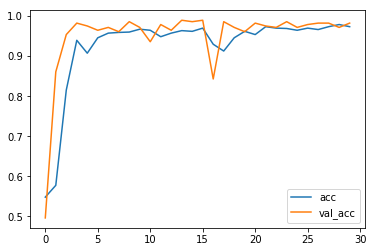

In [49]:
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()